In [23]:
# Import findspark and initialize. 
import findspark
findspark.init()

In [24]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [25]:
# 1. Read in the AWS S3 bucket into a DataFrame.
from pyspark import SparkFiles
url = "https://groupfourproject.s3.ca-central-1.amazonaws.com/bank_churners.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("bank_churners.csv"), sep=",", header=True, ignoreLeadingWhiteSpace=True)
df.show()


24/05/30 19:38:31 WARN SparkContext: The path https://groupfourproject.s3.ca-central-1.amazonaws.com/bank_churners.csv has been added already. Overwriting of added paths is not supported in the current version.


+---------+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+----------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------+
|CLIENTNUM|   Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|Naive_Bayes_Classifier_Attrit

In [26]:
import pandas as pd
pandas_df = df.toPandas()
pandas_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype 
---  ------                                                                                                                              --------------  ----- 
 0   CLIENTNUM                                                                                                                           10127 non-null  object
 1   Attrition_Flag                                                                                                                      10127 non-null  object
 2   Customer_Age                                                                                                                        10127 non-null  object
 3   Gender                                                                                

In [27]:
pandas_df.select_dtypes(include="object").nunique()

CLIENTNUM                                                                                                                             10127
Attrition_Flag                                                                                                                            2
Customer_Age                                                                                                                             45
Gender                                                                                                                                    2
Dependent_count                                                                                                                           6
Education_Level                                                                                                                           7
Marital_Status                                                                                                                            4
Income_Category     

In [28]:
bank_df = pandas_df.drop(["Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1", "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2"], axis=1)

In [29]:
bank_df.describe().T

,count,unique,top,freq
CLIENTNUM,10127,10127,768805383,1
Attrition_Flag,10127,2,Existing Customer,8500
Customer_Age,10127,45,44,500
Gender,10127,2,F,5358
Dependent_count,10127,6,3,2732
Education_Level,10127,7,Graduate,3128
Marital_Status,10127,4,Married,4687
Income_Category,10127,6,Less than $40K,3561
Card_Category,10127,4,Blue,9436
Months_on_book,10127,44,36,2463


In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

In [32]:
data = bank_df.copy()

In [50]:
def summary(data: pd.DataFrame, x: str):
    # Ensure the column is numeric
    data[x] = pd.to_numeric(data[x], errors='coerce')
    
    # Drop NaN values resulting from conversion
    data = data.dropna(subset=[x])
    
    # 5 point summary
    x_min = data[x].min()
    x_max = data[x].max()
    Q1 = data[x].quantile(0.25)
    Q2 = data[x].quantile(0.50)
    Q3 = data[x].quantile(0.75)

    summary_dict = {"Min": x_min, "Q1": Q1, "Q2": Q2, "Q3": Q3, "Max": x_max}
    summary_df = pd.DataFrame(data=summary_dict, index=["Value"])
    print(f"5 Point Summary of {x.capitalize()} Attribute:\n")
    print(tabulate(summary_df, headers="keys", tablefmt="psql"))

    # Plotting
    fig = plt.figure(figsize=(16, 8))
    plt.subplots_adjust(hspace=0.6)
    sns.set_palette("Pastel1")

    # Histogram with mean and median
    plt.subplot(221, frameon=True)
    ax1 = sns.histplot(data[x], kde=True, color="purple")
    ax1.axvline(np.mean(data[x]), color="purple", linestyle="--", label='Mean')
    ax1.axvline(np.median(data[x]), color="black", linestyle="-", label='Median')
    plt.title(f"{x.capitalize()} Density Distribution")
    plt.legend()

    # Violin plot
    plt.subplot(222, frameon=True)
    ax2 = sns.violinplot(x=data[x], palette="Accent")
    plt.title(f"{x.capitalize()} Violinplot")

    # Box plot
    plt.subplot(223, frameon=True)
    ax3 = sns.boxplot(x=data[x], palette="cool", width=0.7, linewidth=0.6, showmeans=True)
    plt.title(f"{x.capitalize()} Boxplot")

    # Cumulative density distribution
    plt.subplot(224, frameon=True)
    ax4 = sns.kdeplot(data[x], cumulative=True)
    plt.title(f"{x.capitalize()} Cumulative Density Distribution")

    plt.show()

5 Point Summary of Customer_age Attribute:

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
|-------+-------+------+------+------+-------|
| Value |    26 |   41 |   46 |   52 |    73 |
+-------+-------+------+------+------+-------+


/Users/chuchu/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chuchu/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


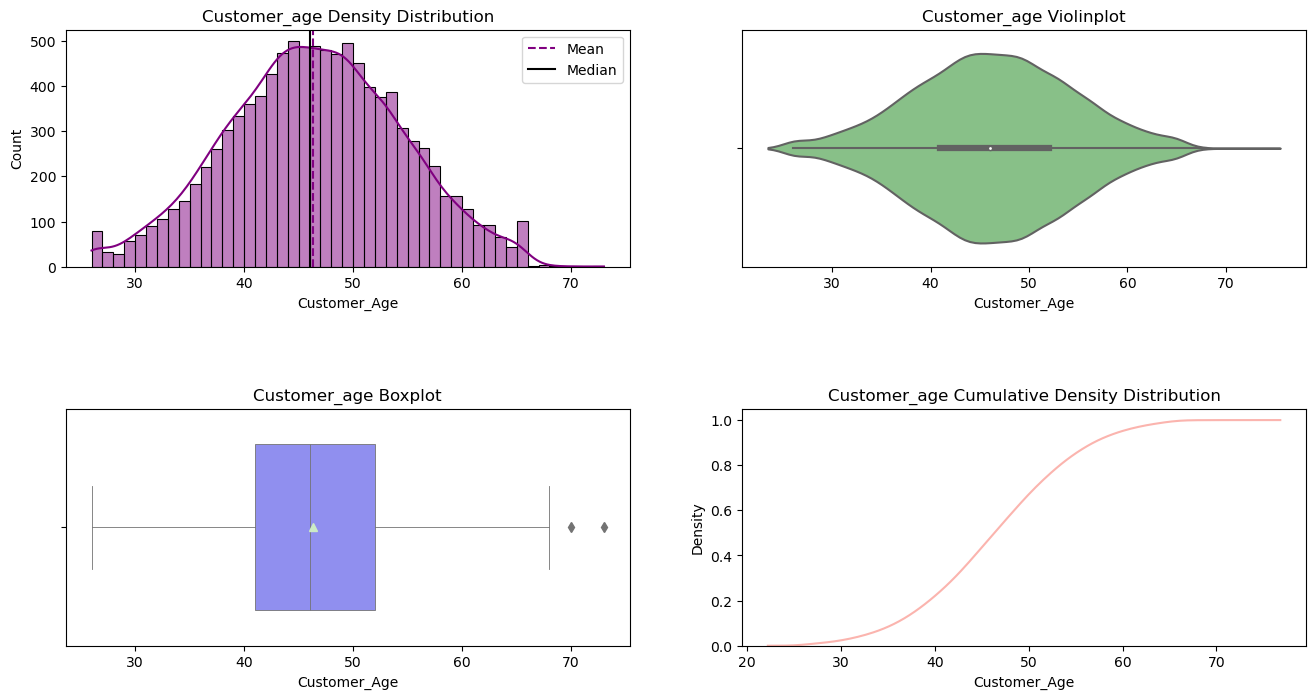

In [49]:
summary(data, "Customer_Age")

5 Point Summary of Dependent_count Attribute:

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
|-------+-------+------+------+------+-------|
| Value |     0 |    1 |    2 |    3 |     5 |
+-------+-------+------+------+------+-------+


/Users/chuchu/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chuchu/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


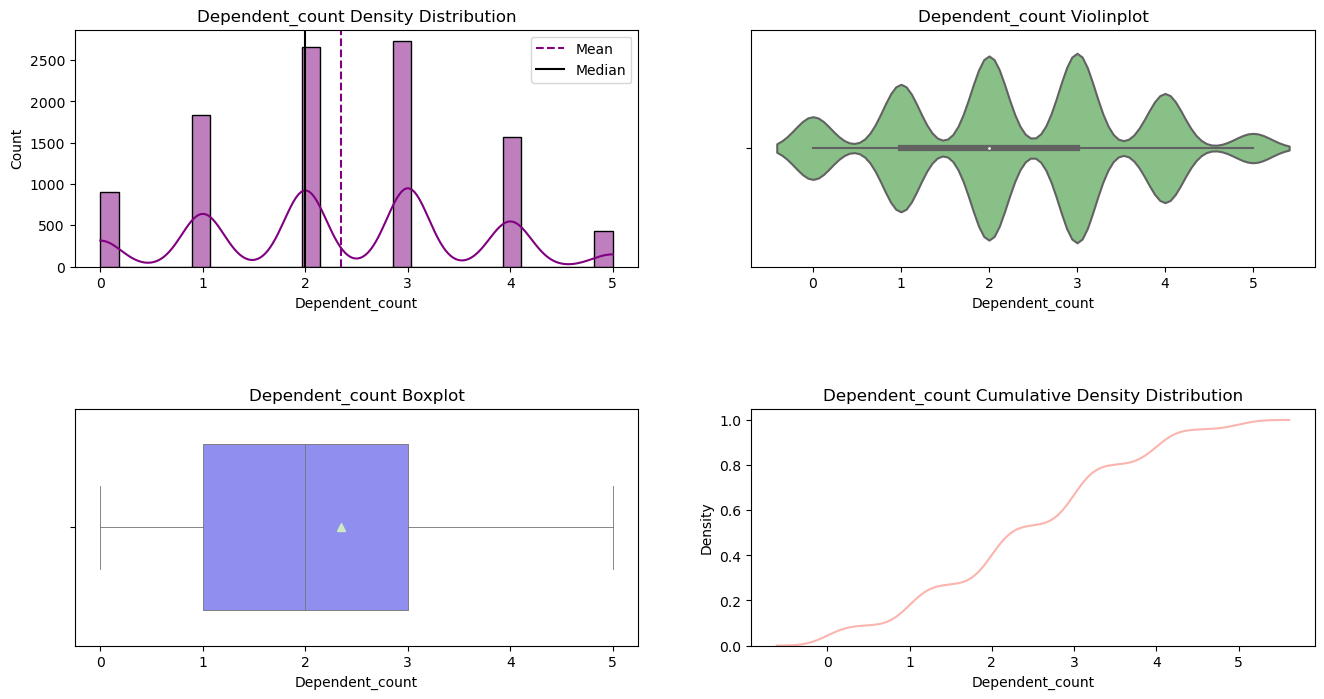

In [52]:
summary(data, "Dependent_count")

5 Point Summary of Months_on_book Attribute:

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
|-------+-------+------+------+------+-------|
| Value |    13 |   31 |   36 |   40 |    56 |
+-------+-------+------+------+------+-------+


/Users/chuchu/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chuchu/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


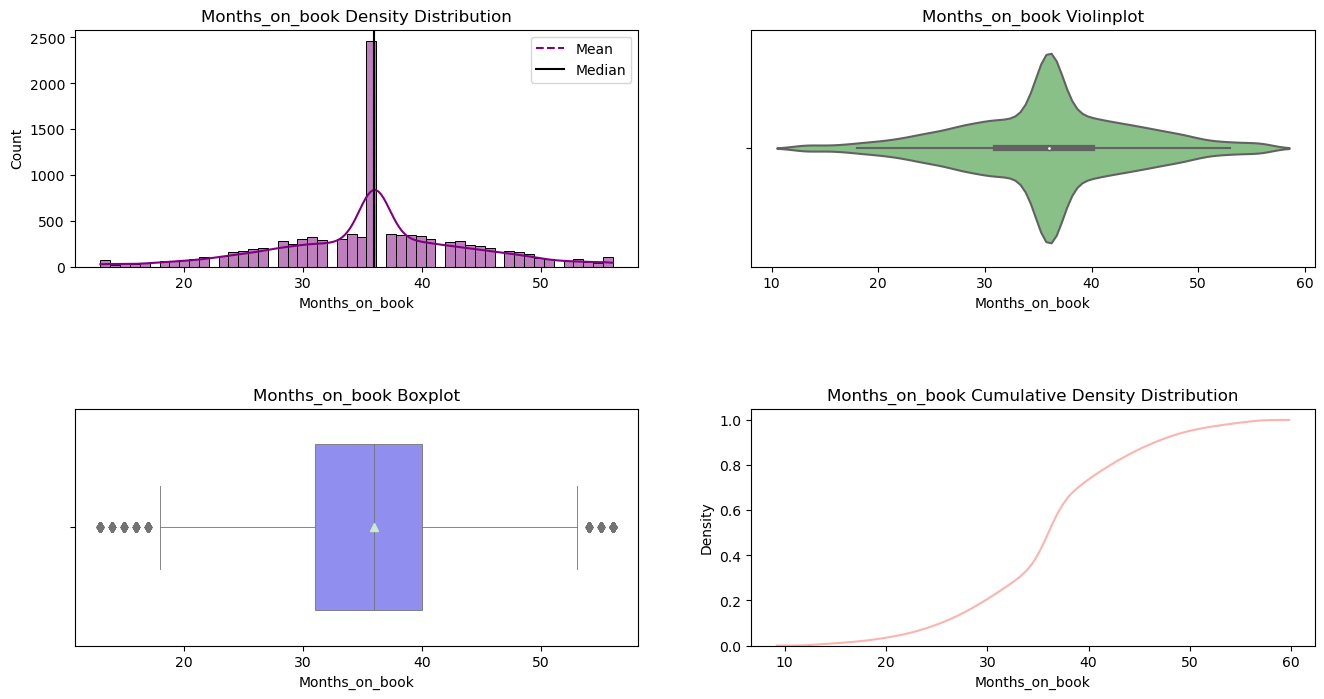

In [53]:
summary(data, "Months_on_book")

5 Point Summary of Months_inactive_12_mon Attribute:

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
|-------+-------+------+------+------+-------|
| Value |     0 |    2 |    2 |    3 |     6 |
+-------+-------+------+------+------+-------+


/Users/chuchu/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chuchu/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


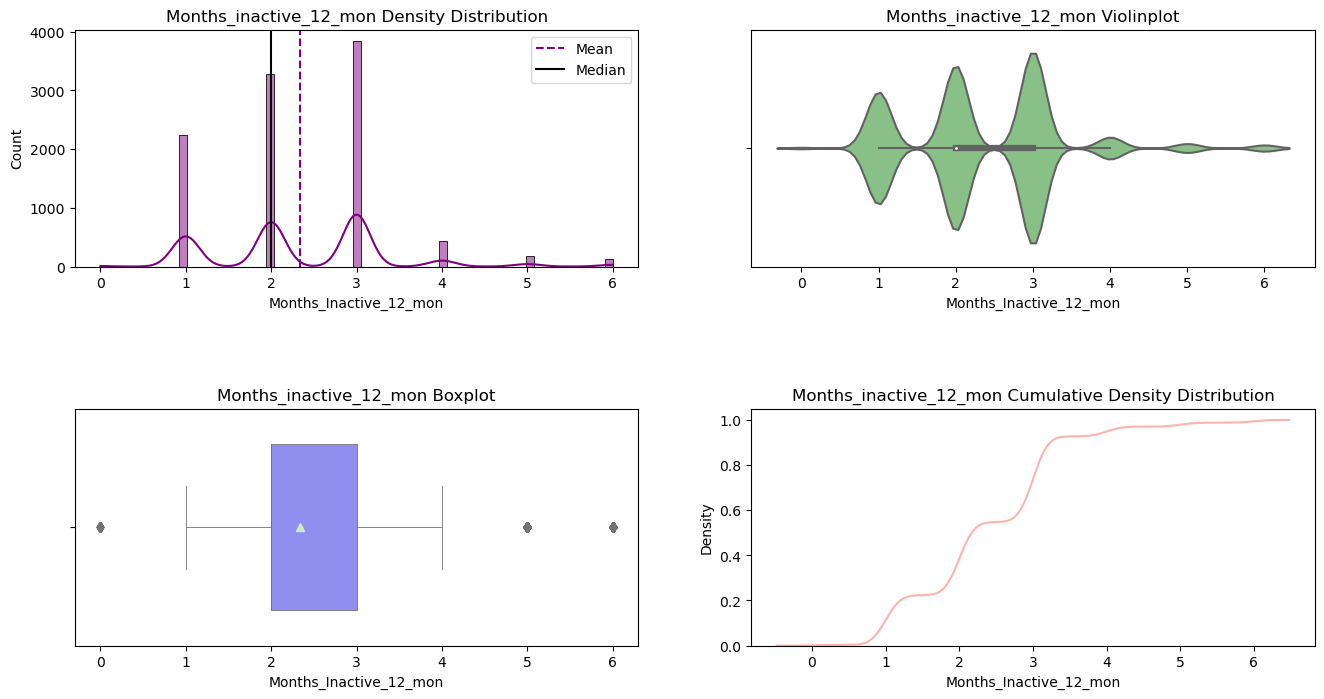

In [54]:
summary(data, "Months_Inactive_12_mon")

5 Point Summary of Credit_limit Attribute:

+-------+--------+------+------+---------+-------+
|       |    Min |   Q1 |   Q2 |      Q3 |   Max |
|-------+--------+------+------+---------+-------|
| Value | 1438.3 | 2555 | 4549 | 11067.5 | 34516 |
+-------+--------+------+------+---------+-------+


/Users/chuchu/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chuchu/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


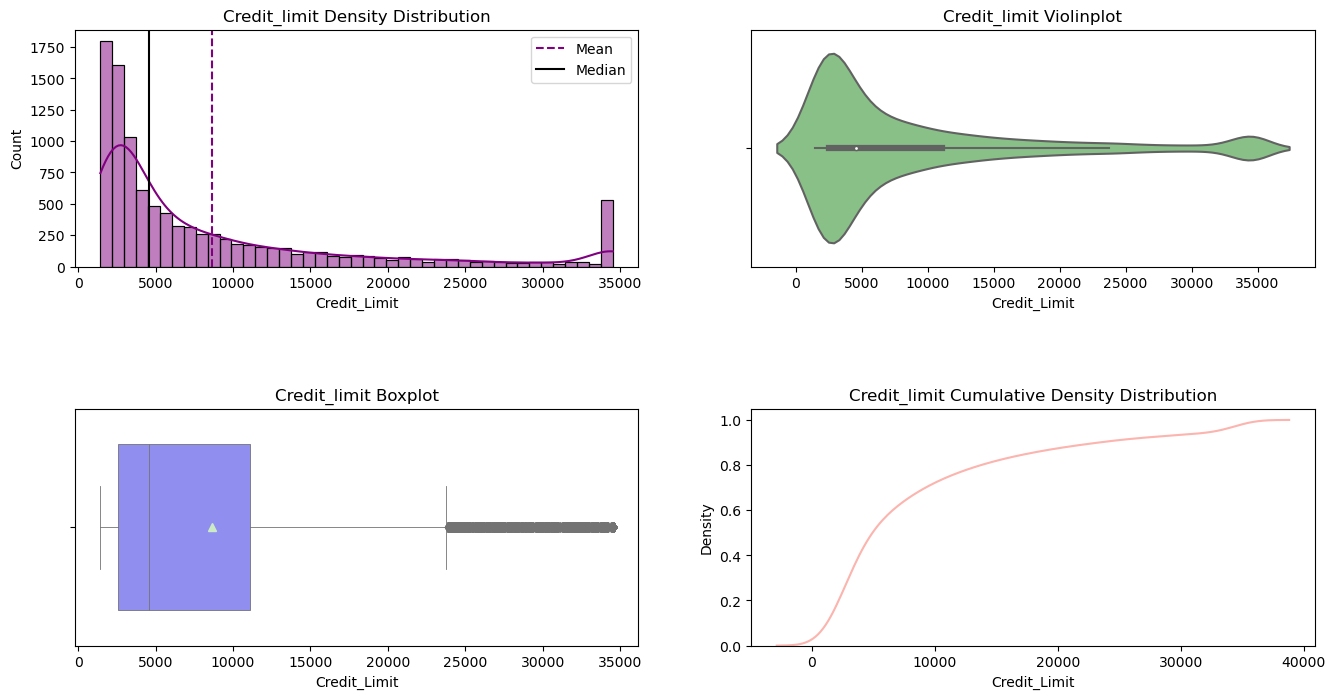

In [55]:
summary(data, "Credit_Limit")